In [1]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
#%matplotlib notebook
import sys
sys.settrace
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pylab import *
import struct
import array
import os
import glob
import h5py
from scipy.interpolate import griddata
import scipy.integrate as integrate

import unicodedata


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["DejaVu Serif"]})
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
plt.rcParams['font.size'] = '20'

/var/folders/xc/18p6rmkn3wv451bp5cpdk04m0000gq/T/ipykernel_10776/486904499.py:26: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


In [2]:
def FitBlackBody(nu_t):
    integral = 0.0;
    nu_2 = nu_t * nu_t;
    nu_3 = nu_t * nu_2;
    if nu_t < 1.5:
        integral = 0.051329911273422 * nu_3 -0.019248716727533 * nu_t * nu_3 + 0.002566495563671 * nu_2 * nu_3;
    elif nu_t < 18.6:
        exp_nu = exp(-nu_t);
        integral = -0.156915538762850 * exp_nu * (nu_3 + 2.69 * nu_2 + 6.714 * nu_t) + 1.000009331428801*(1- exp_nu);
    else:
        integral = 1.0 - 192.1*exp(-0.9014*nu_t)

    return integral;
def BlackBody(nu_t):
    spec=(15/np.pi**4.0)*nu_t**3/(exp(nu_t)-1)
    
    return spec;
    
def dBlackBodydT(nu_t):
    if nu_t < 0.001:
        dbdt = nu_t**2-nu_t**4/12.0
    elif nu_t > 15:
        dbdt = nu_t**4*exp(-nu_t)
    else:
        dbdt=nu_t**4 *exp(nu_t)/(exp(nu_t)-1)**2   
    
    return dbdt;

def powerlaw_spec(nu_t, nu0_t, kappa_0, slope):
    kappa=kappa_0*(nu_t/nu0_t)**slope
    return kappa*BlackBody(nu_t)

def freefree(nu_t,T):
    kappa=15.128*(T**(-3.5))*(nu_t**(-3))*(1-exp(-nu_t))
    return kappa

def freefree_ross(nu_t,T):
    return dBlackBodydT(nu_t)*(nu_t**3)/(0.128815*(T**(-3.5))*(1-exp(-nu_t)))

def freefree_planck(nu_t,T):
    if nu_t < 1.e-5:
        factor = 1-nu_t+nu_t**2/2
    else:
        factor = (1-exp(-nu_t))/(exp(nu_t)-1)
    return (15/np.pi**4.0)*0.128815*(T**(-3.5))*factor

In [3]:
def GenerateFre(nfre,fre_min,fre_max,T):
    #different frequency resolution grid
    log_fre_min=np.log10(fre_min)
    log_fre_max=np.log10(fre_max)
    
    fre_grid=np.arange(nfre+1)
    fre_grid=fre_grid*(log_fre_max-log_fre_min)/np.max(fre_grid)+log_fre_min
    fre_grid=10**fre_grid
    fre_grid=np.insert(fre_grid,0,0)

    kappa_a_fr=np.zeros(nfre+2)
    kappa_p_fr=np.zeros(nfre+2)
    for i in range(0,nfre+1):
        result=integrate.quad(freefree_planck, fre_grid[i]/T, fre_grid[i+1]/T, args=T)
        weight=integrate.quad(BlackBody,fre_grid[i]/T, fre_grid[i+1]/T)
        kappa_p_fr[i]=result[0]/weight[0]
    
    for i in range(0,nfre+1):
        result=integrate.quad(freefree_ross, fre_grid[i]/T, fre_grid[i+1]/T, args=T)
        weight=integrate.quad(dBlackBodydT,fre_grid[i]/T, fre_grid[i+1]/T)
        kappa_a_fr[i]=weight[0]/result[0]
    
    
    result=integrate.quad(freefree_planck, fre_grid[nfre+1]/T, infty, args=T)
    weight=integrate.quad(BlackBody,fre_grid[nfre+1]/T,infty)
    kappa_p_fr[nfre+1]=result[0]/weight[0]


    result=integrate.quad(freefree_ross, fre_grid[nfre+1]/T, infty, args=T)
    weight=integrate.quad(dBlackBodydT,fre_grid[nfre+1]/T,infty)
    kappa_a_fr[nfre+1]=weight[0]/result[0]
    
    return [fre_grid,kappa_a_fr,kappa_p_fr]

In [4]:
T=1
nfre=100
fre_grid=np.arange(nfre+1)
fre_grid=fre_grid*4/np.max(fre_grid)-2
fre_grid=10**fre_grid
fre_grid=np.insert(fre_grid,0,0)

In [5]:
kappa_a_fr=np.zeros(nfre+2)
kappa_p_fr=np.zeros(nfre+2)

In [6]:
for i in range(0,nfre+1):
    result=integrate.quad(freefree_planck, fre_grid[i]/T, fre_grid[i+1]/T, args=T)
    weight=integrate.quad(BlackBody,fre_grid[i]/T, fre_grid[i+1]/T)
    kappa_p_fr[i]=result[0]/weight[0]

In [7]:
for i in range(0,nfre+1):
    result=integrate.quad(freefree_ross, fre_grid[i]/T, fre_grid[i+1]/T, args=T)
    weight=integrate.quad(dBlackBodydT,fre_grid[i]/T, fre_grid[i+1]/T)
    kappa_a_fr[i]=weight[0]/result[0]

In [8]:
result=integrate.quad(freefree_planck, fre_grid[nfre+1]/T, infty, args=T)
weight=integrate.quad(BlackBody,fre_grid[nfre+1]/T,infty)
kappa_p_fr[nfre+1]=result[0]/weight[0]

In [9]:
result=integrate.quad(freefree_ross, fre_grid[nfre+1]/T, infty, args=T)
weight=integrate.quad(dBlackBodydT,fre_grid[nfre+1]/T,infty)
kappa_a_fr[nfre+1]=weight[0]/result[0]

In [10]:
plot_num=np.arange(nfre+2)

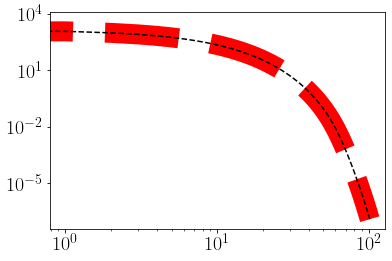

In [11]:
plt.plot(plot_num,kappa_a_fr,color='red',linestyle='dashed',linewidth=20)
plt.plot(plot_num,kappa_p_fr,color='black',linestyle='dashed')
plt.yscale('log')
plt.xscale('log')

In [12]:
output=np.vstack((fre_grid, kappa_a_fr, kappa_p_fr))

In [13]:
np.savetxt('opacities_fre3.txt',np.transpose(output))

In [14]:
print(output.shape)

(3, 102)


In [15]:
print(fre_grid.shape)

(102,)


In [16]:
print(fre_grid)

[0.00000000e+00 1.00000000e-02 1.09647820e-02 1.20226443e-02
 1.31825674e-02 1.44543977e-02 1.58489319e-02 1.73780083e-02
 1.90546072e-02 2.08929613e-02 2.29086765e-02 2.51188643e-02
 2.75422870e-02 3.01995172e-02 3.31131121e-02 3.63078055e-02
 3.98107171e-02 4.36515832e-02 4.78630092e-02 5.24807460e-02
 5.75439937e-02 6.30957344e-02 6.91830971e-02 7.58577575e-02
 8.31763771e-02 9.12010839e-02 1.00000000e-01 1.09647820e-01
 1.20226443e-01 1.31825674e-01 1.44543977e-01 1.58489319e-01
 1.73780083e-01 1.90546072e-01 2.08929613e-01 2.29086765e-01
 2.51188643e-01 2.75422870e-01 3.01995172e-01 3.31131121e-01
 3.63078055e-01 3.98107171e-01 4.36515832e-01 4.78630092e-01
 5.24807460e-01 5.75439937e-01 6.30957344e-01 6.91830971e-01
 7.58577575e-01 8.31763771e-01 9.12010839e-01 1.00000000e+00
 1.09647820e+00 1.20226443e+00 1.31825674e+00 1.44543977e+00
 1.58489319e+00 1.73780083e+00 1.90546072e+00 2.08929613e+00
 2.29086765e+00 2.51188643e+00 2.75422870e+00 3.01995172e+00
 3.31131121e+00 3.630780

In [17]:
nfre2=20
result2=GenerateFre(nfre2,0.1,10,T)

/var/folders/xc/18p6rmkn3wv451bp5cpdk04m0000gq/T/ipykernel_10776/322432750.py:15: RuntimeWarning: overflow encountered in exp
  spec=(15/np.pi**4.0)*nu_t**3/(exp(nu_t)-1)


In [18]:
fre_grid2=result2[0]
kappa_a_fr2=result2[1]
kappa_p_fr2=result2[2]

In [19]:
print(fre_grid2)
print(kappa_a_fr2)
print(kappa_p_fr2)

[ 0.          0.1         0.12589254  0.15848932  0.19952623  0.25118864
  0.31622777  0.39810717  0.50118723  0.63095734  0.79432823  1.
  1.25892541  1.58489319  1.99526231  2.51188643  3.16227766  3.98107171
  5.01187234  6.30957344  7.94328235 10.        ]
[2.06006179e+01 9.33551915e+00 5.80526814e+00 3.59681019e+00
 2.21840228e+00 1.36057790e+00 8.28712843e-01 5.00511322e-01
 2.99208991e-01 1.76687248e-01 1.02836955e-01 5.88620159e-02
 3.30661873e-02 1.82044266e-02 9.81918011e-03 5.19576449e-03
 2.70587572e-03 1.39373216e-03 7.13984677e-04 3.65583563e-04
 1.87738507e-04 8.14803009e-05]
[3.81880647e+01 9.51168824e+00 5.91705696e+00 3.66781651e+00
 2.26354926e+00 1.38930863e+00 8.47007378e-01 5.12160501e-01
 3.06619089e-01 1.81388393e-01 1.05804481e-01 6.07196109e-02
 3.42143153e-02 1.89014379e-02 1.02324405e-02 5.43380010e-03
 2.83859528e-03 1.46532338e-03 7.51450331e-04 3.84686786e-04
 1.97243833e-04 9.42990309e-05]


In [20]:
plot_num2=np.arange(nfre2+2)

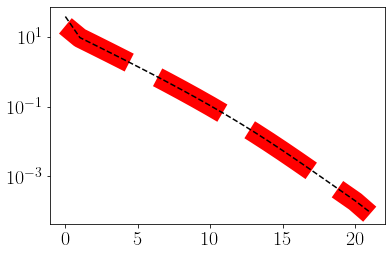

In [21]:
plt.plot(plot_num2,kappa_a_fr2,color='red',linestyle='dashed',linewidth=20)
plt.plot(plot_num2,kappa_p_fr2,color='black',linestyle='dashed')
plt.yscale('log')

In [22]:
output2=np.vstack((fre_grid2, kappa_a_fr2, kappa_p_fr2))

In [23]:
np.savetxt('opacities_fre4.txt',np.transpose(output2))